# Intel Image Classification

By Aviya Oren and Maya Hayat

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This Data contains around 25k images of size 150x150 distributed under 6 categories.
1. 'buildings'
2. 'forest'
3. 'glacier'
4. 'mountain'
5. 'sea'
6. 'street'

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
import glob as gb
import numpy as np
import pandas as pd
import os
import warnings
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import plotly.express as px
import seaborn as sns

from PIL import Image
from tqdm import tqdm
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random

import cv2
import imghdr
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

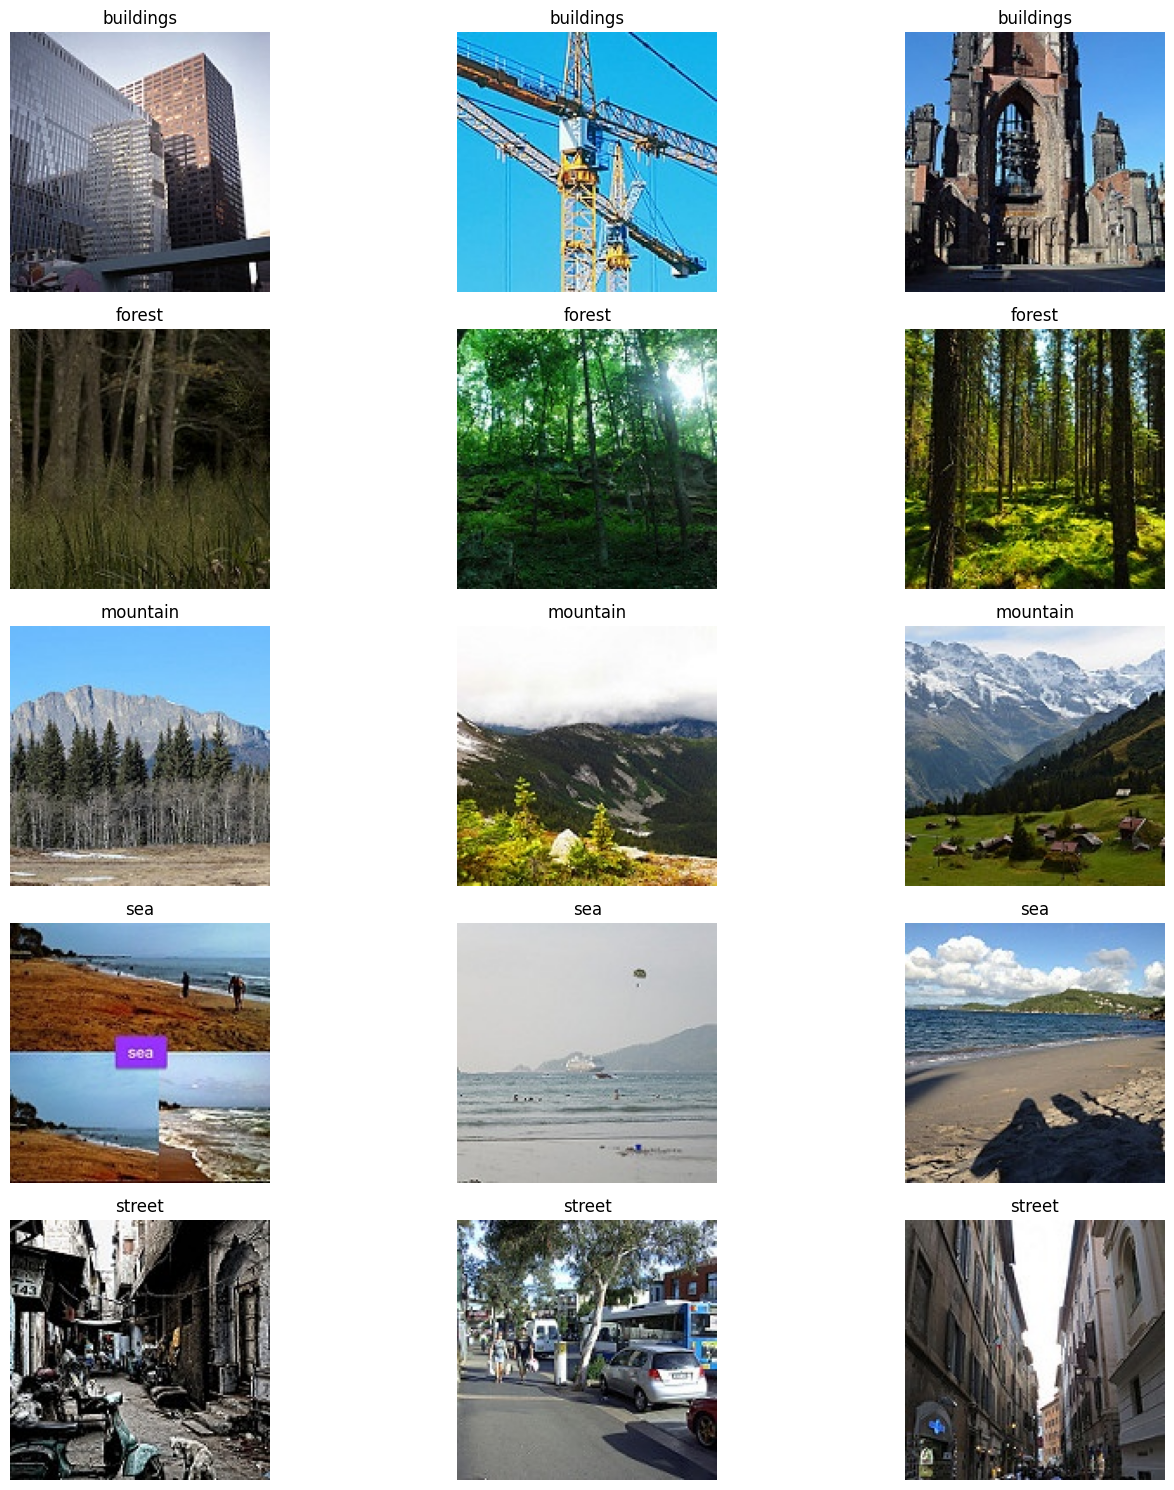

In [58]:
# Path to the directory containing the images
base_directory = 'seg_train/seg_train'

# Categories
categories = ['buildings', 'forest', 'mountain', 'sea', 'street']

# Display three random images for each category
fig, axs = plt.subplots(len(categories), 3, figsize=(15, 15))

for i, category in enumerate(categories):
    category_directory = os.path.join(base_directory, category)
    files = os.listdir(category_directory)
    image_files = [file for file in files if file.endswith(('png', 'jpg', 'jpeg'))]
    random_images = random.sample(image_files, 3)

    for j, image_file in enumerate(random_images):
        image_path = os.path.join(category_directory, image_file)
        image = mpimg.imread(image_path)
        axs[i, j].imshow(image)
        axs[i, j].axis('off')
        axs[i, j].set_title(category)

plt.tight_layout()
plt.show()


In [59]:

for i, category in enumerate(categories):
    category_directory = os.path.join(base_directory, category)
    files = os.listdir(category_directory)
    image_files = [file for file in files if file.endswith(('png', 'jpg', 'jpeg'))]
    print(f"for Traing files is {category} is number of items is === {len(image_files)}")

for Traing files is buildings is number of items is === 2191
for Traing files is forest is number of items is === 2271
for Traing files is mountain is number of items is === 2512
for Traing files is sea is number of items is === 2274
for Traing files is street is number of items is === 2382


In [60]:
test_directory = 'seg_test/seg_test'
for i, category in enumerate(categories):
    category_directory = os.path.join(test_directory, category)
    files = os.listdir(category_directory)
    image_files = [file for file in files if file.endswith(('png', 'jpg', 'jpeg'))]
    print(f"for Testing files is {category} is number of items is === {len(image_files)}")

for Testing files is buildings is number of items is === 437
for Testing files is forest is number of items is === 474
for Testing files is mountain is number of items is === 525
for Testing files is sea is number of items is === 510
for Testing files is street is number of items is === 501


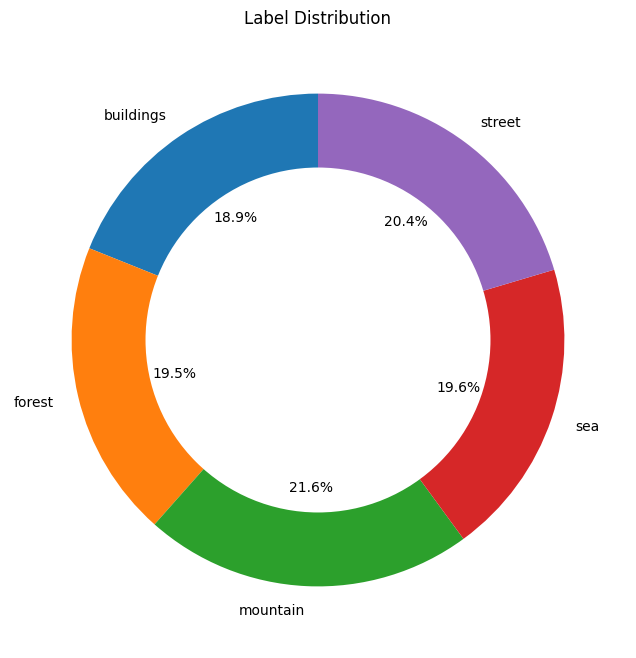

In [61]:
label_counts = {
    'buildings': 2211,
    'forest': 2281,
    'mountain': 2522,
    'sea': 2284,
    'street': 2382
}

labels = list(label_counts.keys())
sizes = list(label_counts.values())

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

# Draw a circle at the center to make it a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Label Distribution')
plt.show()

### Demi-model which randomly assign each image in the test set to one of the specified categories

In [12]:

# Define the categories
categories = ['buildings', 'forest', 'mountain', 'sea', 'street']

# Counters for correct predictions and total predictions
correct_predictions = 0
total_predictions = 0

# Iterate through subdirectories and test images
for category_folder in os.listdir(test_directory):
    category_path = os.path.join(test_directory, category_folder)

    # Check if the item is a directory
    if os.path.isdir(category_path):
        print(f"Category: {category_folder}")

        # Iterate through images in the category
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            predicted_category = random.choice(categories)

            # # Display result
            # print(f"Image: {image_name}")
            # print(f"Actual Category: {category_folder}")
            # print(f"Predicted Category: {predicted_category}")
            # print("\n")

            # Update counters
            total_predictions += 1
            if predicted_category == category_folder:
                correct_predictions += 1

# Calculate accuracy
accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0.0
print(f"Total Correct Predictions: {correct_predictions}")
print(f"Total Predictions: {total_predictions}")
print(f"Accuracy: {accuracy * 100:.2f}%")

Category: buildings
Category: forest
Category: mountain
Category: sea
Category: street
Total Correct Predictions: 471
Total Predictions: 2447
Accuracy: 19.25%


## Simple softmax regression model

Softmax Regression, also known as Multinomial Logistic Regression, is a generalization of logistic regression to multiple classes.

Images are usually represented as 2D or 3D arrays. To use them with Softmax Regression, we need to flatten them into 1D arrays. This is done using image.flatten().
Splitting the dataset:

We split the flattened image data into training and testing sets.
Creating and training the model:

We create a Softmax Regression model using LogisticRegression.
The model is trained on the flattened training data.
Making predictions:

We use the trained model to make predictions on the flattened test set.
Evaluating the model:

We calculate the accuracy of the model on the test set and print a confusion matrix.

In [70]:

# Load the image data and labels
X = []
y = []

for i, category in enumerate(categories):
    category_directory = os.path.join(base_directory, category)
    files = os.listdir(category_directory)
    image_files = [file for file in files if file.endswith(('png', 'jpg', 'jpeg'))]

    for image_file in image_files:
        image_path = os.path.join(category_directory, image_file)
        image = cv2.imread(image_path)
        # You might need to resize the images to a fixed size
        image = cv2.resize(image, (64, 64))
        X.append(image.flatten())  # Flatten the image into a 1D array
        y.append(i)  # Assign a label to the image

X = np.array(X)
y = np.array(y)


In [14]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a logistic regression model
model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=42))

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=categories))


Accuracy: 0.46
Classification Report:
              precision    recall  f1-score   support

   buildings       0.32      0.25      0.28       452
      forest       0.74      0.61      0.67       472
    mountain       0.43      0.52      0.47       490
         sea       0.32      0.43      0.37       443
      street       0.57      0.49      0.52       469

    accuracy                           0.46      2326
   macro avg       0.48      0.46      0.46      2326
weighted avg       0.48      0.46      0.47      2326



In [20]:
def visualize_predictions(X_test, y_true, y_pred, class_names):
    # Take the first 10 samples
    sample_indices = range(10)
    
    X_test = X_test.reshape(-1, 64, 64, 3)

    for i, index in enumerate(sample_indices):
        plt.figure(figsize=(6, 3))

       # Create a figure with two subplots side by side
        fig, axs = plt.subplots(1, 2, figsize=(5, 5))  # Adjust figsize as needed

        # Display the original image
        axs[0].imshow(X_test[index])
        true_label = class_names[(y_true[index])]
        axs[0].set_title(f"Actual: {true_label}", fontsize=12)
        axs[0].axis('off')  # Remove unnecessary axes

        # Display the model's prediction, combining textual and visual elements
        predicted_class = (y_pred[index])
        predicted_label = categories[predicted_class]

        # Option 1: Combine text and image in one subplot
        # axs[1].imshow(X_test[index])  # Duplicate the image for overlay
        # axs[1].text(0.5, 0.5, f"Predicted: {predicted_label}", ha='center', va='center',fontsize=12, color='red')  # Highlight prediction in red
        # axs[1].axis('off')

        # Option 2 (if visual overlay is undesirable):
        axs[1].text(0.5, 0.5, f"Model Prediction:\n{predicted_label}", ha='center', va='center', fontsize=12)
        axs[1].axis('off')

        # Adjust layout and display the combined visualization
        plt.tight_layout()
        plt.show()


The classification report summarizes the model's performance on the test dataset:

Accuracy: 40% - the proportion of correctly classified instances.
Precision:

Varied precision across classes:
'Forest': 69% precision, correctly predicting 'forest' images 69% of the time.
'Street': 48% precision.
Recall:

Varied recall across classes:
'Forest': 57% recall, correctly identifying 57% of all 'forest' images.
'Mountain': 43% recall.
F1-Score:

Weighted average of Precision and Recall.
Provided for each class, with macro and weighted averages.
Support:

Number of actual occurrences of the class in the dataset.
Conclusion:

Varying performance across classes, with higher precision for 'forest' and 'street.'
Recall rates differ, indicating varied class identification.
Overall accuracy of 40% suggests room for improvement.
Consider advanced models, hyperparameter tuning, or a more complex neural network.
Analyze misclassified instances, explore data augmentation, or collect more data.
Convolutional Neural Networks (CNNs) are often more effective for image classification tasks due to their ability to capture spatial dependencies. Consider experimenting with CNNs for improved results.

<Figure size 600x300 with 0 Axes>

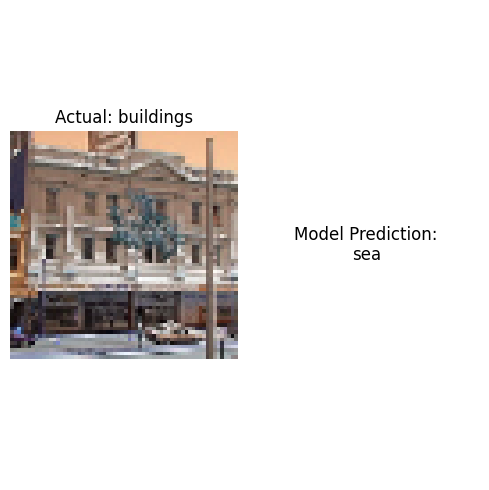

<Figure size 600x300 with 0 Axes>

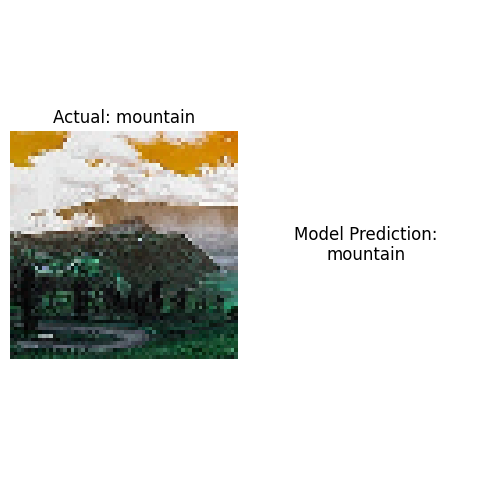

<Figure size 600x300 with 0 Axes>

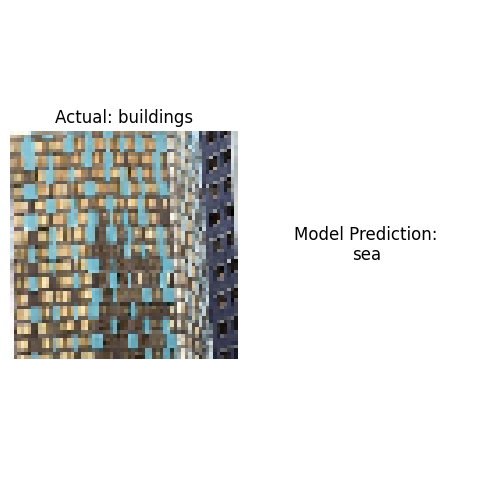

<Figure size 600x300 with 0 Axes>

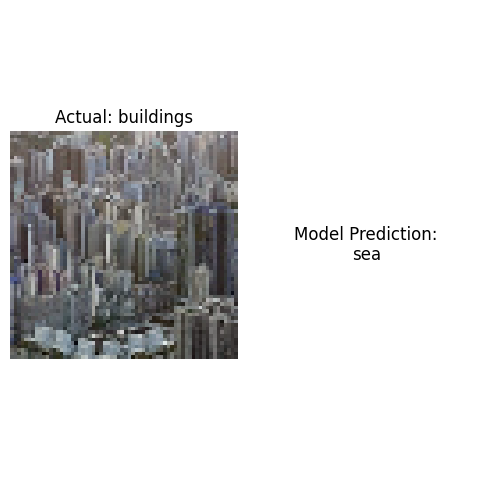

<Figure size 600x300 with 0 Axes>

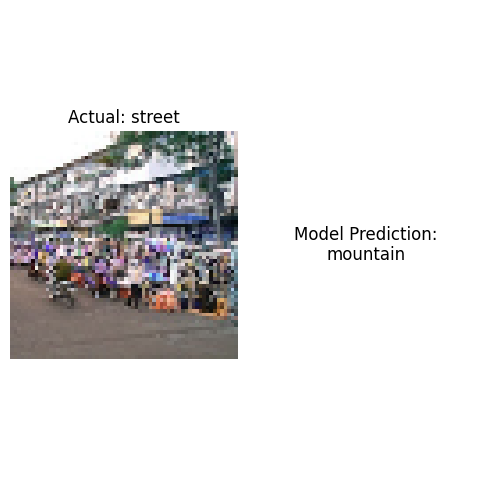

<Figure size 600x300 with 0 Axes>

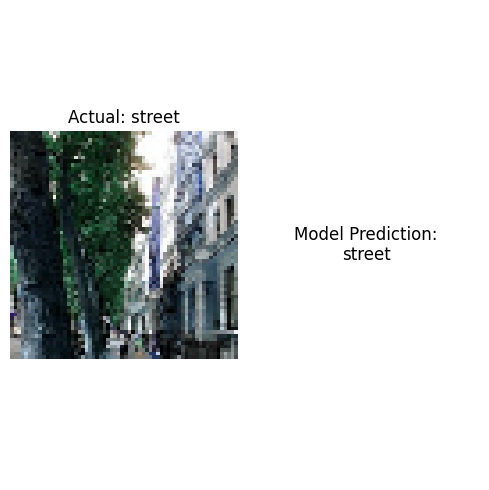

<Figure size 600x300 with 0 Axes>

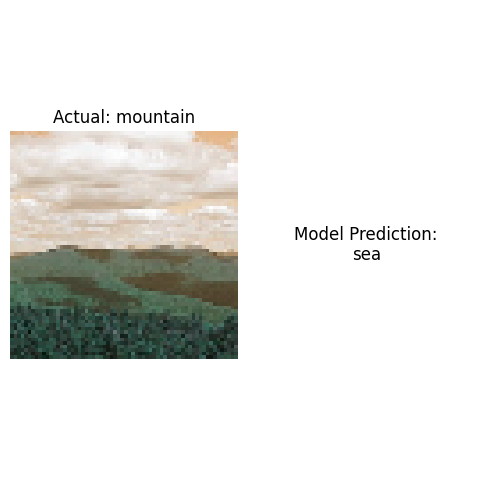

<Figure size 600x300 with 0 Axes>

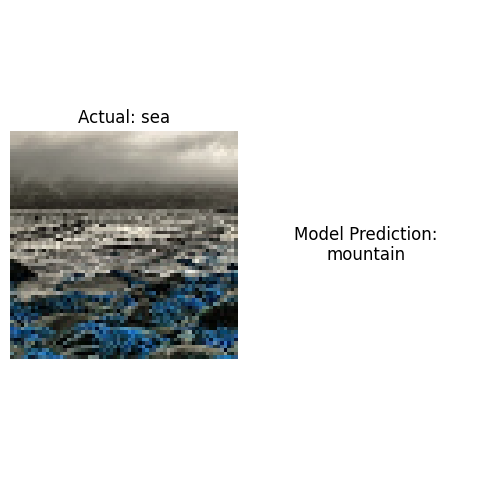

<Figure size 600x300 with 0 Axes>

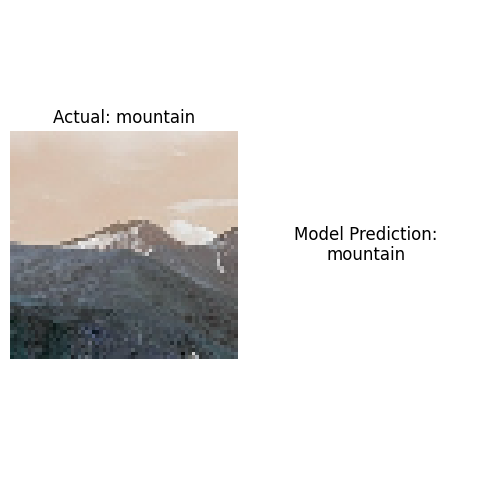

<Figure size 600x300 with 0 Axes>

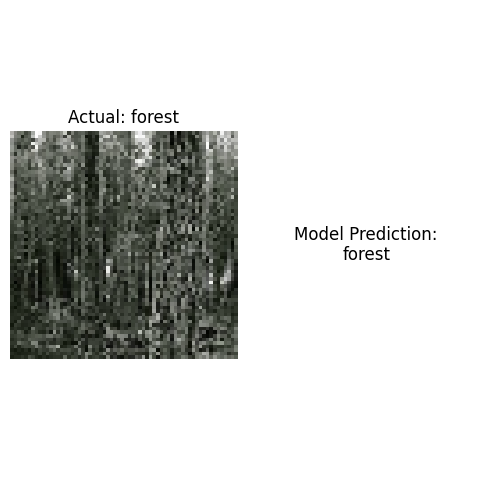

In [21]:

visualize_predictions(X_test, y_test, y_pred, categories)


# logistic regression with grid search- find the best hyperparameters.

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
len(X_train)/5

1860.8

In [68]:

from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10],
    'logisticregression__solver': ['lbfgs', 'newton-cg', 'liblinear']
}

# Create the pipeline with LogisticRegression
pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=42))

# Create the GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)


In [71]:

def batch_train_predict(X, y, batch_size, model_class=LogisticRegression, **model_kwargs):
  """
  Trains a model on the data in batches and predicts on unseen data.

  Args:
      X: Training features.
      y: Training targets.
      batch_size: Size of data batches.
      model_class: The model class to use (e.g., LogisticRegression).
      model_kwargs: Keyword arguments to pass to the model constructor.

  Returns:
      y_pred: Predictions on unseen data.
  """
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  scaler = StandardScaler()
  X_train_scaled = []

  for i in range(0, len(X_train), batch_size):
    batch_X = X_train[i:i+batch_size]
    batch_X_scaled = scaler.fit_transform(batch_X)
    X_train_scaled.append(batch_X_scaled)

  # Combine scaled batches into a single array
  X_train_scaled = np.concatenate(X_train_scaled, axis=0)

  model = model_class(**model_kwargs)
  model.fit(X_train_scaled, y_train)

  X_test_scaled = scaler.transform(X_test)
  y_pred = model.predict(X_test_scaled)
  return y_pred

# Call the function with your data, batch size, and model details
batch_size = 1860
y_pred = batch_train_predict(X, y, batch_size, model_class=LogisticRegression, max_iter=1000, random_state=42)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with batch processing: {accuracy:.2f}")

Accuracy with batch processing: 0.34


## More complex model:

In [22]:
data_directory = 'seg_train/seg_train'

In [23]:
test_data = 'seg_test/seg_test'

In [24]:
os.listdir(data_directory)

['buildings', 'forest', 'mountain', 'sea', 'street']

In [25]:
os.listdir(test_data)

['buildings', 'forest', 'mountain', 'sea', 'street']

In [26]:
# According to Kaggle the original size if 150*150, therefore we want to keep it as is
data = tf.keras.utils.image_dataset_from_directory(data_directory, image_size = (150,150), batch_size=128)

Found 11630 files belonging to 5 classes.


In [27]:
test = tf.keras.utils.image_dataset_from_directory(test_data, image_size = (150,150), batch_size=128)

Found 2447 files belonging to 5 classes.


In [28]:
data_iterator = data.as_numpy_iterator()
test_iterator = test.as_numpy_iterator()

In [29]:
batch = data_iterator.next()

In [30]:
batch_test = test_iterator.next()

In [31]:
# where the first batch is our data and the second is the labels
len(batch),len(batch_test)

(2, 2)

In [32]:
batch[0].shape

(128, 150, 150, 3)

In [33]:
batch_test[0].shape

(128, 150, 150, 3)

In [34]:
batch[1]

array([0, 1, 3, 1, 0, 1, 2, 2, 4, 2, 3, 0, 3, 4, 1, 1, 0, 2, 4, 0, 4, 1,
       4, 4, 4, 1, 4, 4, 4, 2, 3, 0, 2, 3, 3, 2, 2, 1, 1, 4, 2, 4, 0, 2,
       4, 0, 1, 4, 0, 4, 4, 3, 0, 3, 0, 2, 4, 0, 3, 4, 4, 3, 0, 2, 0, 2,
       3, 2, 3, 4, 4, 1, 2, 3, 1, 1, 1, 2, 0, 3, 2, 4, 2, 2, 0, 1, 4, 1,
       3, 0, 3, 0, 4, 0, 0, 0, 1, 0, 4, 3, 1, 1, 2, 4, 2, 4, 1, 1, 0, 3,
       4, 3, 0, 4, 2, 4, 1, 0, 2, 3, 0, 2, 2, 4, 3, 0, 2, 2])

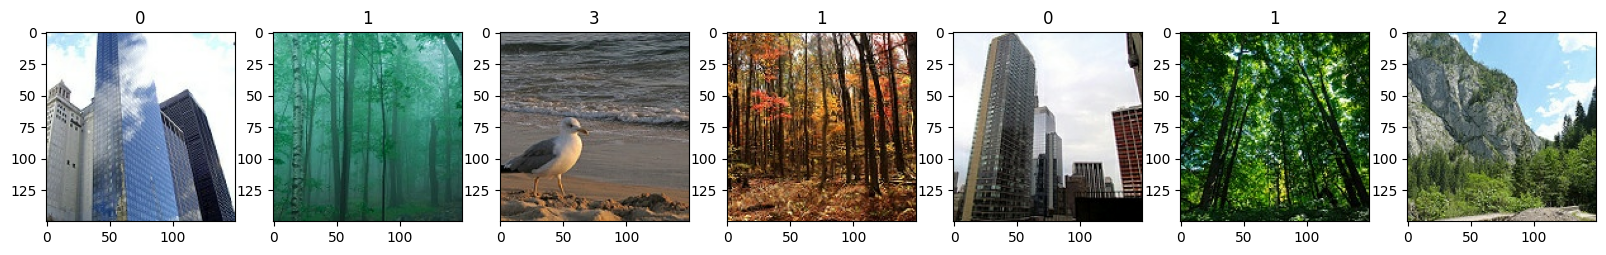

In [35]:
fig, ax = plt.subplots(ncols=7, figsize=(20,20))
for idx, img in enumerate(batch[0][:7]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

As we can see above the following numbers match the following catagories:
0. building
1. forest
2. glacier
3. mountain
4. sea
5. street

In [36]:
print("max:" , batch[0].max(), " and min: ", batch[0].min())

max: 255.0  and min:  0.0


In [37]:
data = data.map(lambda x, y: (x / 255.0, y))

In [38]:
test = test.map(lambda x, y: (x / 255.0, y))

In [39]:
data.as_numpy_iterator().next()[0].max(), data.as_numpy_iterator().next()[0].min()

(1.0, 0.0)

In [40]:
train_size = int(len(data)*0.8)
val_size = int(len(data)*0.2)

In [41]:
print(train_size, val_size)

72 18


In [42]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)

In [43]:
# Number of batches * 32 images
len(train), len(val), len(test)

(72, 18, 20)

In [44]:
input_shape = (150, 150, 3)
num_classes = 6  # Number of classes

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras import backend as K
# Define the model
simple_model = Sequential()
simple_model.add(Input(shape=input_shape))
simple_model.add(Flatten())
simple_model.add(Dense(128, activation='relu'))
simple_model.add(Dropout(0.3))  # Adjust the dropout rate as needed
simple_model.add(Dense(num_classes, activation='softmax'))

def categorical_crossentropy_smooth(y_true, y_pred, smooth_factor=0.1):
    y_true_smooth = y_true * (1 - smooth_factor) + smooth_factor / num_classes
    return K.categorical_crossentropy(y_true_smooth, y_pred)

simple_model.compile(optimizer='adam', loss=categorical_crossentropy_smooth, metrics=['accuracy'])



In [51]:

features, labels = batch

one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=num_classes)


In [52]:
tf.debugging.check_numerics(features, "Data contains NaN or infinity values.")
tf.debugging.enable_check_numerics()


INFO:tensorflow:Enabled check-numerics callback in thread MainThread


In [53]:
simple_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 67500)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       8,640,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,640,902 (32.96 MB)

 Trainable params: 8,640,902 (32.96 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
# Train the model
simple_model.fit(features, one_hot_labels, epochs=5, batch_size=128, validation_split=0.2)


Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step - accuracy: 0.1863 - loss: 13.1473 - val_accuracy: 0.2308 - val_loss: 12.5019
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step - accuracy: 0.2059 - loss: 12.8565 - val_accuracy: 0.1923 - val_loss: 13.0598
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step - accuracy: 0.2059 - loss: 12.8629 - val_accuracy: 0.1923 - val_loss: 13.0598
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step - accuracy: 0.1863 - loss: 13.1473 - val_accuracy: 0.1923 - val_loss: 13.0598
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step - accuracy: 0.2157 - loss: 12.7207 - val_accuracy: 0.1923 - val_loss: 13.0598


Despite attempts to make the model better, there was no improvement. As we continued training, we noticed NaN gradients, indicating our current approach isn't right for this classification task. It's clear we need to try a different method. We might consider using more advanced models, adjusting settings, or changing the neural network structure to handle the complexities of image classification better.

## Using more complex CNN model...

In [ ]:
model= tf.keras.Sequential([
    # First layer
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    # Second layer
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Third layer
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 64)       

The optimizer='adam' like we learn in class

The first Dense layer has 128 neurons. It is a **fully connected** layer, connecting every neuron from the previous layer. The total number of parameters is 2367616.
The final Dense layer has **6 neurons**, corresponding to the number of classes in your classification task. The 774 parameters are associated with this layer.

The total number of parameters in your model is 2424710, and all of them are trainable. Non-trainable parameters typically refer to parameters in layers like BatchNormalization or Dropout where the weights are not updated during training.

This is our first trying to make a CNN model...


In [ ]:
logdir = '/content/drive/MyDrive/logs'

In [ ]:
callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

## Create a small subset of our training data, for quik practice.

In [ ]:

# Define the fraction to subsample (e.g., 0.1 for 10% of the data)
subsample_fraction = 0.1

# Calculate the number of samples to keep
subsample_size = int(train_size * subsample_fraction)

# Take a subsample of the training data
subsampled_train = train.take(subsample_size)

# Print information about the subsampled dataset
print(f"Original training size: {train_size}")
print(f"Subsampled training size: {subsample_size}")

# Example: Load a batch from the subsampled training dataset
subsampled_data_iterator = subsampled_train.as_numpy_iterator()
subsampled_batch = subsampled_data_iterator.next()

# Access the features and labels
features_subsampled, labels_subsampled = subsampled_batch


Original training size: 88
Subsampled training size: 8


In [ ]:
history = model.fit(train, epochs=20, validation_data = val, callbacks=[callback])

Epoch 1/20
46/88 [==============>...............] - ETA: 9:55 - loss: 1.2461 - accuracy: 0.5131 

KeyboardInterrupt: 

In [ ]:
# Load the saved model
#loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/first_model_8epc.h5')

In [ ]:
model.save('best_model.h5')

NameError: name 'model' is not defined

In [ ]:
# Compile the loaded model
#loaded_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

# Train the loaded model
#history = loaded_model.fit(train_images_norm, train_labels, epochs=8, validation_data=(val_images_norm, val_labels), callbacks=[callback])


In [ ]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

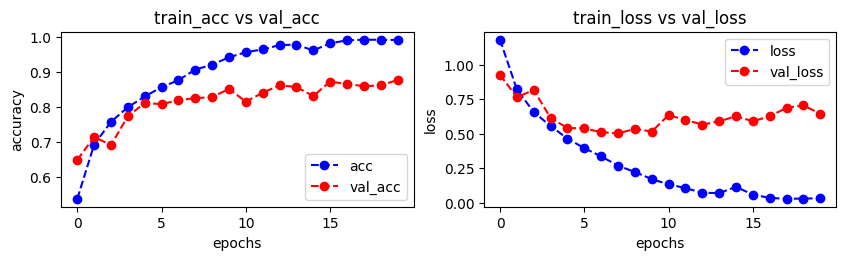

In [ ]:
plot_accuracy_loss(history)

In [ ]:
from tensorflow.keras.metrics import CategoricalAccuracy

pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    y_pred = np.argmax(yhat,axis=1)
    pre.update_state(y, y_pred)
    re.update_state(y, y_pred)
    acc.update_state(y, y_pred)

3/3 [==============================] - 1s 204ms/step


In [ ]:
print("Precision: {:.4f}, Recall: {:.4f}, Accuracy:{:.4f}".format(pre.result(), re.result(), acc.result()))

Precision: 0.9672, Recall: 0.9499, Accuracy:0.6667


# VGG Model

In [ ]:
from tensorflow.keras.applications import VGG16
model_vgg = VGG16(weights='imagenet', include_top = False, input_shape=(150, 150, 3))

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
model_vgg.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_vgg = model_vgg.fit(train, epochs=10, validation_data = val, callbacks=[callback])

Epoch 1/10
88/88 [==============================] - 4231s 49s/step - loss: 1.0840 - accuracy: 0.5823 - val_loss: 0.8714 - val_accuracy: 0.6639
Epoch 2/10
88/88 [==============================] - 597s 7s/step - loss: 0.7180 - accuracy: 0.7392 - val_loss: 0.7871 - val_accuracy: 0.7137
Epoch 3/10
88/88 [==============================] - 567s 6s/step - loss: 0.5998 - accuracy: 0.7805 - val_loss: 0.5671 - val_accuracy: 0.8000
Epoch 4/10
88/88 [==============================] - 566s 6s/step - loss: 0.5072 - accuracy: 0.8203 - val_loss: 0.5446 - val_accuracy: 0.8061
Epoch 5/10
88/88 [==============================] - 566s 6s/step - loss: 0.4128 - accuracy: 0.8521 - val_loss: 0.5334 - val_accuracy: 0.8137
Epoch 6/10
88/88 [==============================] - 562s 6s/step - loss: 0.3311 - accuracy: 0.8843 - val_loss: 0.5057 - val_accuracy: 0.8300
Epoch 7/10
88/88 [==============================] - 555s 6s/step - loss: 0.2692 - accuracy: 0.9090 - val_loss: 0.5036 - val_accuracy: 0.8354
Epoch 8/10


In [ ]:
model_vgg.save('vgg_model.h5')

In [ ]:
plt.plot(history_vgg.history["accuracy"])
plt.plot(history_vgg.history['val_accuracy'])
plt.plot(history_vgg.history['loss'])
plt.plot(history_vgg.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

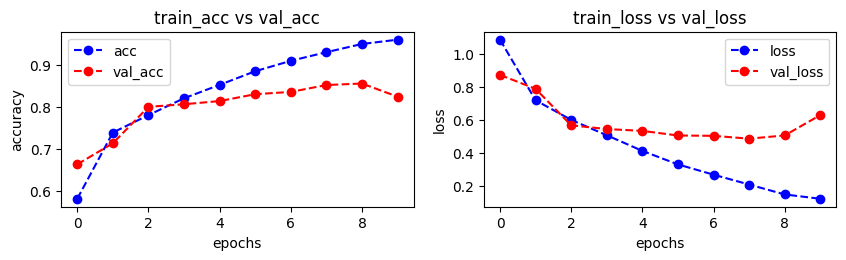

In [ ]:
plot_accuracy_loss(history_vgg)

In [ ]:
from tensorflow.keras.metrics import CategoricalAccuracy

pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model_vgg.predict(X, batch_size=128)
    # print(y.shape, yhat.shape)
    # break
    y_pred = np.argmax(yhat,axis=1)
    pre.update_state(y, y_pred)
    re.update_state(y, y_pred)
    acc.update_state(y, y_pred)

1/1 [==============================] - 1s 1s/step


In [ ]:
print("Precision: {:.4f}, Recall: {:.4f}, Accuracy:{:.4f}".format(pre.result(), re.result(), acc.result()))

In [ ]:
from tensorflow.keras.metrics import CategoricalAccuracy

pre_test = Precision()
re_test = Recall()
acc_test = CategoricalAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch_test
    yhat = model_vgg.predict(X, batch_size=128)
    # print(y.shape, yhat.shape)
    # break
    y_pred = np.argmax(yhat,axis=1)
    pre_test.update_state(y, y_pred)
    re_test.update_state(y, y_pred)
    acc_test.update_state(y, y_pred)

In [ ]:
# Use the appropriate evaluation metric for your task (e.g., accuracy, precision, recall)
model_loss, model_accuracy = model_vgg.evaluate(test)
print(f"Test Loss: {model_loss}, Test Accuracy: {model_accuracy}")


ValueError: The last dimension of the inputs to a Dense layer should be defined. Found None. Full input shape received: (None, None)